In [1]:
import numpy as np
import cv2
from PIL import Image
import open3d as o3d
import json
import os
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import BoxVisibility
from utils import *
from vis_utils import plot_3d_image_

from typing import Tuple, List, Dict, Union

%matplotlib inline

In [2]:
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
# Load the information from .txt file in JSON format
sample_path = os.getcwd()+'/dataset/samples/sample_841dd6709e9b4d7c9d6bf888f1fe6d7e_file.txt'

# This is a Dictionary of lists of dictionaries
data_json = load_file(sample_path)
data_json['instance'][0]

{'annotation_token': '4b8f390f86aa433cac6c4247f907565f',
 'sample_token': '841dd6709e9b4d7c9d6bf888f1fe6d7e',
 'camera_token': '39caaccc75dd4e38b8fe6f40e81f5621',
 'pointcloud_path': '/home/sherlock/Documents/3d_obj_detection/dataset/ann_points_lidar/pc_anno_4b8f390f86aa433cac6c4247f907565f.txt',
 'pcl_shape': [3, 794],
 'img_pc_path': '/home/sherlock/Documents/3d_obj_detection/dataset/ann_points_cam/img_pc_anno_4b8f390f86aa433cac6c4247f907565f.txt',
 'img_pcl_shape': [4, 794],
 'pcd_path': '/home/sherlock/Documents/3d_obj_detection/dataset/pcd_segmentation/pcd_segmentation_4b8f390f86aa433cac6c4247f907565f.pcd',
 'point_features_path': '/home/sherlock/Documents/3d_obj_detection/dataset/point_features/pcd_segmentation_4b8f390f86aa433cac6c4247f907565f.txt',
 'position_coord': [6.053757848521915, 4.1099025347326315, -0.899958760271085],
 'wlh_values': [1.772, 4.294, 1.597],
 'orientation_value': -177.91535813202847,
 'category': 'vehicle'}

In [4]:
box_vis_level = BoxVisibility.ANY
    
sample_record = nusc.get('sample', data_json['instance'][0]['sample_token'])
cam = nusc.get('sample_data', data_json['instance'][0]['camera_token'])

# Plot CAMERA view.
data_path, boxes, camera_intrinsic = nusc.get_sample_data(data_json['instance'][0]['camera_token'], selected_anntokens=[data_json['instance'][0]['annotation_token']])

https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/utils/data_classes.py#L572

https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L1316

In [5]:
# Map corners to 2D image plane
corners = view_points(boxes[0].corners(), view = camera_intrinsic, normalize = True)[:2, :]
corners

array([[ 657.62822195,  349.02747755,  359.27611364,  670.76369136,
        1122.13114312,  881.39986672,  888.02214236, 1129.82464543],
       [ 441.59444803,  462.60432058,  835.65849907,  902.18408203,
         456.3328353 ,  467.38155699,  693.60066339,  712.01881351]])

In [6]:
def draw_rect(selected_corners, color, axes):
            prev = selected_corners[-1]
            for corner in selected_corners:
                axes.plot([prev[0], corner[0]], [prev[1], corner[1]], color = color, linewidth=2)
                prev = corner

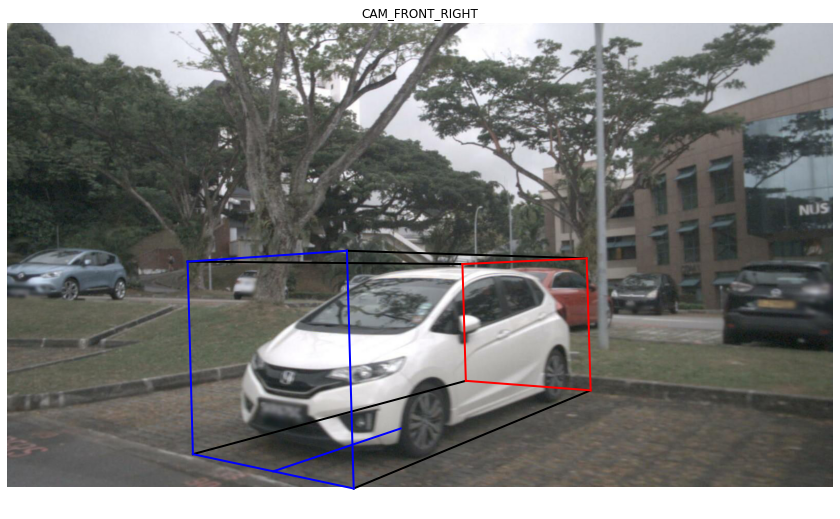

In [7]:
# Create axis and image
fig, axes = plt.subplots(1, 1, figsize=(18, 9))
# Open image of the interest camera
im = Image.open(osp.join(nusc.dataroot, cam['filename']))
axes.imshow(im)

# Draw the sides of the bounding box
colors = ('b', 'r', 'k')

for i in range(4):
    axes.plot([corners.T[i][0], corners.T[i + 4][0]],
              [corners.T[i][1], corners.T[i + 4][1]],
              color=colors[2], linewidth = 2)
    
# Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
draw_rect(corners.T[:4], colors[0], axes)
draw_rect(corners.T[4:], colors[1], axes)

# Draw line indicating the front
center_bottom_forward = np.mean(corners.T[2:4], axis=0)
center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
axes.plot([center_bottom[0], center_bottom_forward[0]],
          [center_bottom[1], center_bottom_forward[1]],
          color=colors[0], linewidth=2)
    
axes.set_title(nusc.get('sample_data', cam['token'])['channel'])
axes.axis('off')
axes.set_aspect('equal')

In [8]:
box = nusc.get_box(data_json['instance'][0]['annotation_token'])
box

label: nan, score: nan, xyz: [663.54, 1821.01, 0.96], wlh: [1.77, 4.29, 1.60], rot axis: [0.00, 0.00, 1.00], ang(degrees): -134.70, ang(rad): -2.35, vel: nan, nan, nan, name: vehicle.car, token: 4b8f390f86aa433cac6c4247f907565f

In [9]:
# From camera to ego
cs_rec_cam = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
# From ego to world coordinate frame Cam
pose_rec_cam = nusc.get('ego_pose', cam['ego_pose_token'])

pointsensor_token = sample_record['data']['LIDAR_TOP']
# Camera sample        
point_data = nusc.get('sample_data', pointsensor_token) # Sample LiDAR info

# From LiDAR to ego
cs_rec_point = nusc.get('calibrated_sensor', point_data['calibrated_sensor_token'])
# Transformation metadata from ego to world coordinate frame
pose_rec_point = nusc.get('ego_pose', point_data['ego_pose_token'])

## From LiDAR to CAM

In [10]:
# From LiDAR point sensor to ego vehicle
box.rotate(Quaternion(cs_rec_point['rotation']))
box.translate(np.array(cs_rec_point['translation']))

#  Move box to world coordinate frame
box.rotate(Quaternion(pose_rec_point['rotation']))
box.translate(np.array(pose_rec_point['translation']))

# Move box to ego vehicle coord system.
box.translate(-np.array(pose_rec_cam['translation']))
box.rotate(Quaternion(pose_rec_cam['rotation']).inverse)

#  Move box to sensor coord system (cam).
box.translate(-np.array(cs_rec_cam['translation']))
box.rotate(Quaternion(cs_rec_cam['rotation']).inverse)

## Move from world coordinate to cam

In [11]:
# Move box to ego vehicle coord system.
box.translate(-np.array(pose_rec_cam['translation']))
box.rotate(Quaternion(pose_rec_cam['rotation']).inverse)

#  Move box to sensor coord system (cam).
box.translate(-np.array(cs_rec_cam['translation']))
box.rotate(Quaternion(cs_rec_cam['rotation']).inverse)

In [12]:
box

label: nan, score: nan, xyz: [-1552.18, -1516.07, -2043.15], wlh: [1.77, 4.29, 1.60], rot axis: [0.79, 0.62, 0.05], ang(degrees): 174.57, ang(rad): 3.05, vel: nan, nan, nan, name: vehicle.car, token: 4b8f390f86aa433cac6c4247f907565f

In [13]:
boxes[0]

label: nan, score: nan, xyz: [0.02, 0.61, 6.64], wlh: [1.77, 4.29, 1.60], rot axis: [0.35, 0.66, -0.67], ang(degrees): 143.15, ang(rad): 2.50, vel: nan, nan, nan, name: vehicle.car, token: 4b8f390f86aa433cac6c4247f907565f

In [14]:
boxes[0].corners()

array([[-0.52176648, -1.96608728, -1.91975839, -0.47543758,  1.96283816,
         0.51851735,  0.56484625,  2.00916706],
       [-0.18650868, -0.14021471,  1.45609862,  1.40980464, -0.24367553,
        -0.19738156,  1.39893177,  1.35263779],
       [ 4.37586692,  5.40142935,  5.39461757,  4.36905515,  7.87756762,
         8.90313004,  8.89631827,  7.87075584]])

In [15]:
ann_metadata = nusc.get('sample_annotation' ,data_json['instance'][0]['annotation_token'])
ann_metadata

{'token': '4b8f390f86aa433cac6c4247f907565f',
 'sample_token': '841dd6709e9b4d7c9d6bf888f1fe6d7e',
 'instance_token': '63510eb8f6ed4b3189002b1f2648ea1f',
 'visibility_token': '4',
 'attribute_tokens': ['58aa28b1c2a54dc88e169808c07331e3'],
 'translation': [663.541, 1821.007, 0.96],
 'size': [1.772, 4.294, 1.597],
 'rotation': [-0.385116936394389, 0.0, 0.0, 0.922867783218268],
 'prev': '94afa5424cec4602a6fd29115d044f2b',
 'next': 'd21cd2c3f0174e6aad904b1e93e14493',
 'num_lidar_pts': 482,
 'num_radar_pts': 1,
 'category_name': 'vehicle.car'}

In [16]:
q0 = Quaternion(axis=[0, 0, 1], angle = -2.35)
q0

Quaternion(0.385543073615936, -0.0, -0.0, -0.922689838671033)

In [17]:
bbox = Box([0.02, 0.61, 6.64], [1.77, 4.29, 1.60], q0, name = 'vehicle.car', 
           token = data_json['instance'][0]['annotation_token'])

In [18]:
bbox

label: nan, score: nan, xyz: [0.02, 0.61, 6.64], wlh: [1.77, 4.29, 1.60], rot axis: [-0.00, -0.00, -1.00], ang(degrees): 134.65, ang(rad): 2.35, vel: nan, nan, nan, name: vehicle.car, token: 4b8f390f86aa433cac6c4247f907565f

In [22]:
bbox = nusc.get_box(data_json['instance'][0]['annotation_token'])
bbox

label: nan, score: nan, xyz: [663.54, 1821.01, 0.96], wlh: [1.77, 4.29, 1.60], rot axis: [0.00, 0.00, 1.00], ang(degrees): -134.70, ang(rad): -2.35, vel: nan, nan, nan, name: vehicle.car, token: 4b8f390f86aa433cac6c4247f907565f

In [23]:
# Move box to ego vehicle coord system.
bbox.translate(-np.array(pose_rec_point['translation']))
bbox.rotate(Quaternion(pose_rec_point['rotation']).inverse)

#  Move box to sensor coord system (cam).
bbox.translate(-np.array(cs_rec_point['translation']))
bbox.rotate(Quaternion(cs_rec_point['rotation']).inverse)

In [24]:
bbox

label: nan, score: nan, xyz: [6.05, 4.11, -0.90], wlh: [1.77, 4.29, 1.60], rot axis: [0.00, -0.00, -1.00], ang(degrees): -177.92, ang(rad): -3.11, vel: nan, nan, nan, name: vehicle.car, token: 4b8f390f86aa433cac6c4247f907565f

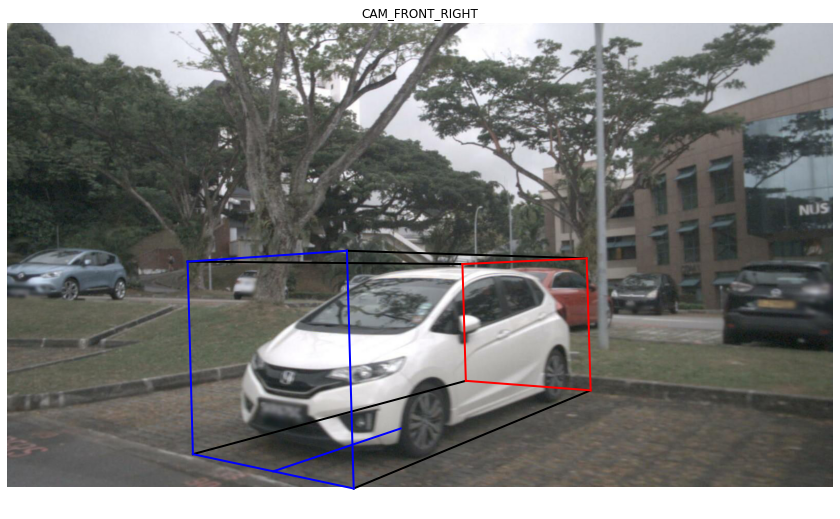

In [25]:
plot_3d_image_(nusc, cam['token'], 'Vehicle', sample_record['token'], bbox)